Some code and ideas from https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-rnn-for-text-classification-tasks and https://medium.com/@spandey8312/text-classification-using-custom-data-and-pytorch-d88ba1087045

In [1]:
import os, pickle, itertools, json
from pprint import pprint as pp
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
from torch import tensor, nn, optim
from torch.nn import functional as F
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

import nltk
from nltk.corpus import brown

nltk.download('brown')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_PATH = '/content/gdrive/MyDrive/School/LING581/final'

Mounted at /content/gdrive


In [3]:
# Paths
vocab_file_path = 'vocab'
embedding_folder_path = 'embedding-models'
doc_classifier_folder_path = 'doc-classifier-models'
stats_path = 'test-embeddings_stats'

In [4]:
# Load vocab
PAD = '<PAD>'

abs_vocab_file_path = os.path.join(DRIVE_PATH, vocab_file_path + '.pt')

vocab = torch.load(abs_vocab_file_path)

# Build dataset

In [5]:
class Samples(Dataset):
  '''Dataset that returns a tuple of a text category and a paragraph (a list of
  sentences).
  '''

  def __init__(self, min_samples):
    '''Drop categories with less than `min_samples` samples.'''

    # Categories as strings
    s_cats = brown.categories()
    self.le = LabelEncoder().fit(s_cats)
    self.cats = self.le.transform(s_cats)

    all_labels = list()
    all_paras = list()

    for cat, s_cat in zip(self.cats, s_cats):
      paras = brown.paras(categories=s_cat)
      num_paras = len(paras)

      # For each paragraph, convert tokens to vocab indices and combine
      # paragraph (list of sentence lists of tokens) into a single list of token
      # IDs.
      paras_ids = [list(itertools.chain(
                    *[vocab.lookup_indices(sent)
                    for sent in para]))
                  for para in paras]

      self.all_labels.extend([cat] * num_paras)
      self.all_paras.extend(paras_ids)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.labels[idx], self.paras[idx]

In [6]:
class Samples(Dataset):
  '''Dataset that returns a tuple of a text category and a paragraph (a list of
  sentences).
  '''

  def __init__(self, min_samples=None):
    '''Drop categories with less than `min_samples` samples if not None.'''

    # Categories as strings
    s_cats = brown.categories()

    labels = list()
    self.paras = list()

    for s_cat in s_cats:
      paras = brown.paras(categories=s_cat)
      num_paras = len(paras)

      if min_samples is not None and num_paras < min_samples:
        continue # to the next category

      # For each paragraph, convert tokens to vocab indices and combine
      # paragraph (list of sentence lists of tokens) into a single list of token
      # IDs.
      paras_ids = [list(itertools.chain(
                    *[vocab.lookup_indices(sent)
                    for sent in para]))
                  for para in paras]

      labels.extend([s_cat] * num_paras)
      self.paras.extend(paras_ids)

    self.labels = LabelEncoder().fit_transform(labels)
    self.cats = set(self.labels)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.labels[idx], self.paras[idx]

In [7]:
def collate_batch(batch):
  '''Given a batch of labels and paragraphs, create a batch.

  Return:
    labels (tensor): the labels for the paragraphs
    # packed_paras (PackedSequence): the packed, padded paragraphs (batch-first)
  '''

  padding_value = vocab[PAD]

  labels = tensor([label for label, _ in batch]).to(device)

  paras_list = [tensor(para) for _, para in batch]
  lengths = [len(para) for _, para in batch]
  padded_paras = pad_sequence(paras_list, batch_first=True,
                              padding_value=padding_value).to(device)
  packed_paras = pack_padded_sequence(padded_paras, lengths, batch_first=True,
                                      enforce_sorted=False).to(device)

  return labels, padded_paras, lengths

In [9]:
dataset = Samples()
freqs = Counter(dataset.labels)
total = freqs.total()
dist = Counter({ label : freq/total for label, freq in freqs.items() })

freqs, dist

(Counter({0: 1387,
          1: 1405,
          2: 1003,
          3: 1043,
          4: 851,
          5: 1119,
          6: 254,
          7: 1418,
          8: 1203,
          9: 1164,
          10: 2234,
          11: 369,
          12: 629,
          13: 1253,
          14: 335}),
 Counter({0: 0.0885300312759303,
          1: 0.08967894300121274,
          2: 0.06401991446990489,
          3: 0.0665730516371992,
          4: 0.054317993234186505,
          5: 0.0714240122550584,
          6: 0.016212421012318887,
          7: 0.09050871258058339,
          8: 0.07678560030637646,
          9: 0.0742962915682645,
          10: 0.14259271079338737,
          11: 0.023552690368290035,
          12: 0.04014808195570307,
          13: 0.07997702176549436,
          14: 0.02138252377608987}))

In [8]:
min_samples = 1000
dataset = Samples(min_samples)
freqs = Counter(dataset.labels)
total = freqs.total()
dist = Counter({ label : freq/total for label, freq in freqs.items() })

freqs, dist

(Counter({0: 1387,
          1: 1405,
          2: 1003,
          3: 1043,
          4: 1119,
          5: 1418,
          6: 1203,
          7: 1164,
          8: 2234,
          9: 1253}),
 Counter({0: 0.10484541537531182,
          1: 0.1062060624385819,
          2: 0.07581827802554993,
          3: 0.07884193816615012,
          4: 0.0845868924332905,
          5: 0.10718875198427696,
          6: 0.0909365787285509,
          7: 0.08798851009146572,
          8: 0.16887141885252097,
          9: 0.09471615390430116}))

# Define model

In [ ]:
class RNNClassifier(nn.Module):
  def __init__(self, embedding_path, hidden_dim, num_layers, num_classes,
               model_type, bidirectional=True, ):
    """`model_type` should be one of 'rnn' or 'gru'"""

    super(RNNClassifier, self).__init__()

    embedding_path = os.path.join(DRIVE_PATH, embedding_folder_path,
                                  embedding_path)
    embedding_state_dict = torch.load(embedding_path, map_location=device)
    embedding_tensor = embedding_state_dict['target_embedding.weight']
    self.embedding = nn.Embedding.from_pretrained(embedding_tensor)

    _, embedding_dim = self.embedding.weight.size()

    match model_type:
      case 'rnn': recurrent = nn.RNN
      case 'gru': recurrent = nn.GRU
      case _: raise ValueError('invalid model_type parameter')

    self.recurrent = recurrent(input_size=embedding_dim, hidden_size=hidden_dim,
                               num_layers=num_layers, batch_first=True,
                               bidirectional=bidirectional)

    self.linear = nn.Linear(hidden_dim * 2 if bidirectional else 1, num_classes)

  def forward(self, paras, lengths):
    embeddings = self.embedding(paras)
    packed = pack_padded_sequence(embeddings, lengths, batch_first=True,
                                  enforce_sorted=False)

    # (batch_size) x (sequence length) x (hidden_dim)
    output, _ = self.recurrent(embeddings)

    # Take the mean across the sequence, yielding (batch_size) x (hidden_dim)
    output_mean = output.mean(dim=1)

    return self.linear(output_mean)

# Define training and evaluation procedures

In [ ]:
def train(model,
          train_loader,
          valid_loader,
          criterion,
          optimizer,
          num_epochs=5,):

  train_losses = list()
  val_losses = list()
  batch_idxs = [0]

  for epoch in range(num_epochs):
    print(f'epoch: {epoch+1:>2}/{num_epochs}', end='')
    num_batches = len(train_loader)

    model.train()
    for batch_num, (labels, paras, lengths) in enumerate(train_loader):
      outputs = model(paras, lengths)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_losses.append(loss.item())

    # For syncing train and val loss plots
    # idx = batch_num + batch_idxs[-1]
    batch_idxs.append(batch_num + batch_idxs[-1])

    model.eval()
    total_val_loss = 0.
    total_val_samples = 0
    with torch.no_grad():
      for labels, paras, lengths in valid_loader:
        outputs = model(paras, lengths)
        val_loss = criterion(outputs, labels)

        total_val_loss += val_loss.item() * len(labels)
        total_val_samples += len(labels)

    val_losses.append(total_val_loss / total_val_samples)

    print(f' val loss: {val_losses[-1]:.4f}')

  return train_losses, val_losses, batch_idxs[1:]

In [ ]:
def eval(model, test_loader):
  model.eval()
  with torch.no_grad():
    total_test_samples = 0
    correct_predictions = 0

    predicted_labels_list = list()
    targets_list = list()

    for labels, paras, lengths in test_loader:
      outputs = model(paras, lengths)

      _, predicted_labels = torch.max(outputs, dim=1)

      total_test_samples += len(labels)
      correct_predictions += (predicted_labels == labels).sum().item()

      predicted_labels_list.extend(predicted_labels.tolist())
      targets_list.extend(labels.tolist())

    # Calculate evaluation metrics
    accuracy = correct_predictions / total_test_samples

    micro_precision = precision_score(targets_list, predicted_labels_list, average='micro')
    macro_precision = precision_score(targets_list, predicted_labels_list, average='macro', zero_division=0)

    micro_recall = recall_score(targets_list, predicted_labels_list, average='micro')
    macro_recall = recall_score(targets_list, predicted_labels_list, average='macro')

    micro_f1 = f1_score(targets_list, predicted_labels_list, average='micro')
    macro_f1 = f1_score(targets_list, predicted_labels_list, average='macro')

    print(f'Accuracy: {accuracy:.4f}')

    print('Micro')
    print(f' precision: {micro_precision:.4f}')
    print(f' recall: {micro_recall:.4f}')
    print(f' F1-score: {micro_f1:.4f}')

    print('Macro')
    print(f' precision: {macro_precision:.4f}')
    print(f' recall: {macro_recall:.4f}')
    print(f' F1-score: {macro_f1:.4f}')

    return {'accuracy' : accuracy,
            'micro-precision' : micro_precision,
            'micro-recall' : micro_recall,
            'micro-f1-score' : micro_f1,
            'macro-precision' : macro_precision,
            'macro-recall' : macro_recall,
            'macro-f1-score' : macro_f1}

# Train

In [ ]:
# Parameters
min_samples = 1000

dataset = Samples(min_samples)

torch.manual_seed(0)
train_data, val_data, test_data = \
  random_split(dataset, (0.7, 0.15, 0.15))

------------------------ dot.pt -------------------------
epoch:  1/20 val loss: 2.2088
epoch:  2/20 val loss: 2.2017
epoch:  3/20 val loss: 2.1867
epoch:  4/20 val loss: 1.9450
epoch:  5/20 val loss: 1.8399
epoch:  6/20 val loss: 1.7954
epoch:  7/20 val loss: 1.7852
epoch:  8/20 val loss: 1.7576
epoch:  9/20 val loss: 1.7462
epoch: 10/20 val loss: 1.7374
epoch: 11/20 val loss: 1.7249
epoch: 12/20 val loss: 1.7112
epoch: 13/20 val loss: 1.7078
epoch: 14/20 val loss: 1.7050
epoch: 15/20 val loss: 1.6897
epoch: 16/20 val loss: 1.6745
epoch: 17/20 val loss: 1.6656
epoch: 18/20 val loss: 1.6493
epoch: 19/20 val loss: 1.6497
epoch: 20/20 val loss: 1.6516
Accuracy: 0.3498
Micro
 precision: 0.3498
 recall: 0.3498
 F1-score: 0.3498
Macro
 precision: 0.2754
 recall: 0.3016
 F1-score: 0.2684
------------------------ cos.pt -------------------------
epoch:  1/20 val loss: 2.2043
epoch:  2/20 val loss: 2.1958
epoch:  3/20 val loss: 1.9407
epoch:  4/20 val loss: 1.8500
epoch:  5/20 val loss: 1.7967

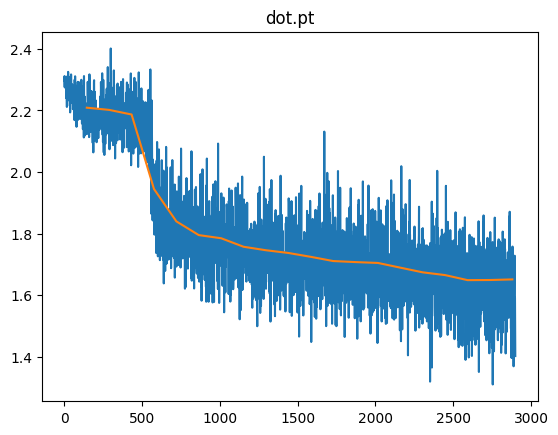

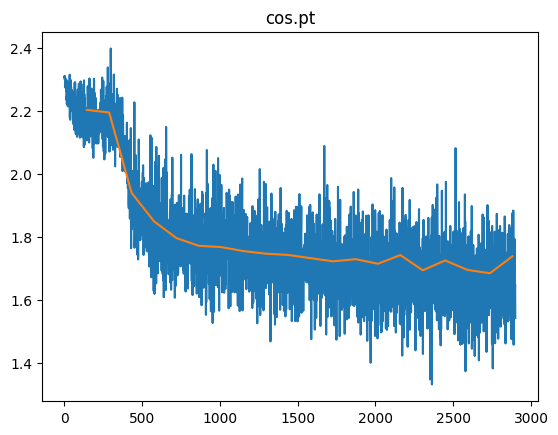

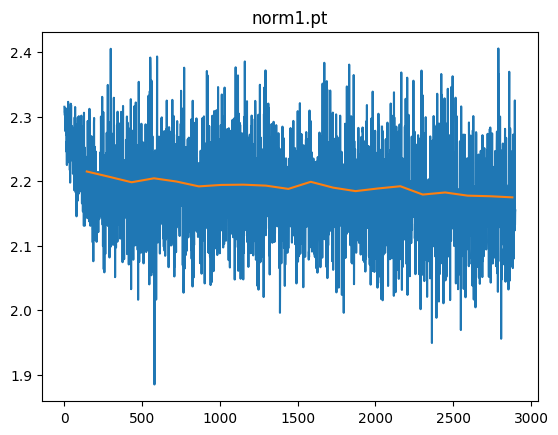

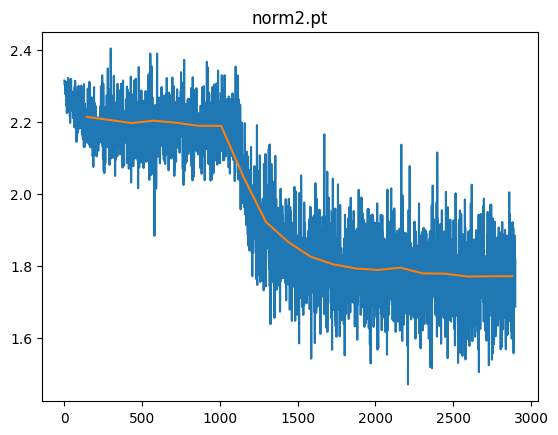

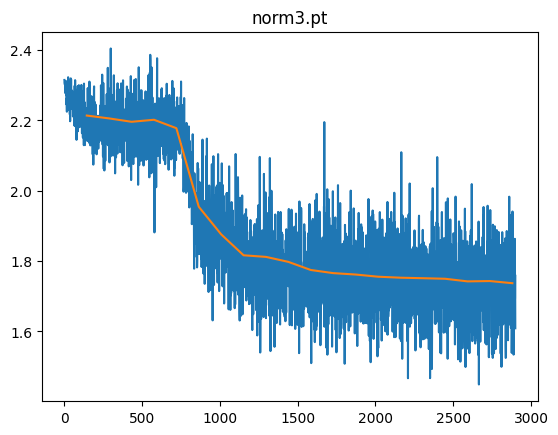

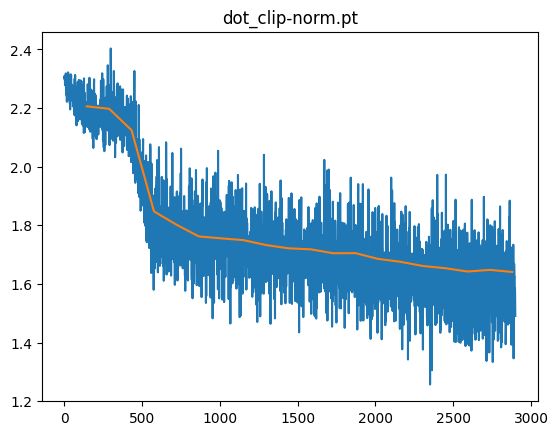

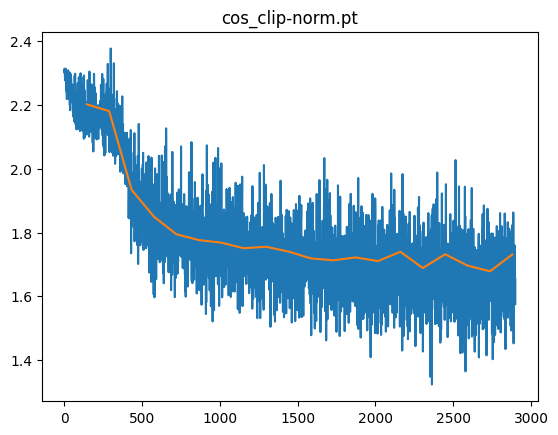

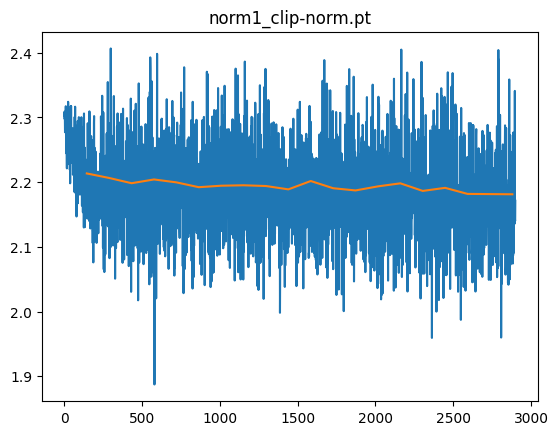

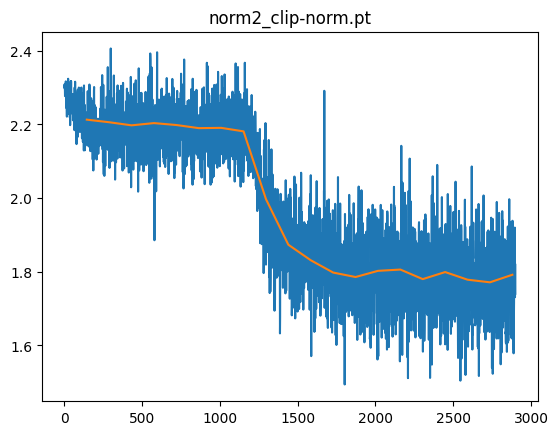

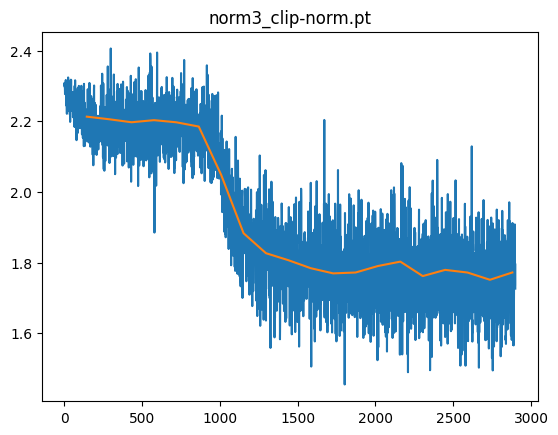

In [ ]:
embedding_paths = os.listdir(os.path.join(DRIVE_PATH, embedding_folder_path))

# Parameters
model_type = 'gru'
hidden_dim = 64
num_layers = 5
learning_rate = 0.0001
batch_size = 64

num_epochs = 20

criterion = nn.CrossEntropyLoss()

stats = dict()

for embedding_path in embedding_paths:
  print(f"{' ' + embedding_path + ' ':-^57}")

  model = RNNClassifier(embedding_path, hidden_dim, num_layers, len(dataset.cats),
                        model_type).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  torch.manual_seed(0)
  train_loader, val_loader, test_loader = \
    map(lambda dataset: DataLoader(
      dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch),
    (train_data, val_data, test_data))

  train_losses, val_losses, batch_idxs = \
    train(model, train_loader, val_loader, criterion, optimizer, num_epochs, )

  model_stats = eval(model, test_loader)

  fig, ax = plt.subplots(1, 1)
  ax.plot(train_losses)
  ax.plot(batch_idxs, val_losses)
  ax.set_title(f'{embedding_path}')
  fig.show()

  # abs_model_path = os.path.join(DRIVE_PATH, doc_classifier_folder_path,
  #                               embedding_path)
  # torch.save(model.state_dict(), abs_model_path)

  stats[embedding_path.replace('.pt', '')] = {'val_losses' : val_losses,
                                              'stats' : model_stats}

with open(os.path.join(DRIVE_PATH, stats_path + '.json'), 'w') as file:
  json.dump(stats, file)